## AutoEncoder (リサーチワークショップⅡ, 2024)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

In [6]:
# 再現性を担保するため，乱数を固定
np.random.seed(1234)
torch.manual_seed(1234)

# 演算に用いるデバイスを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tensor へ変換するための transforms
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])

# データの取得
root = os.path.join('data', 'mnist')
mnist_train = torchvision.datasets.MNIST(root=root, download=True, train=True, transform=transform)
mnist_test =  torchvision.datasets.MNIST(root=root, download=True, train=False, transform=transform)

# data loader の定義
train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=1, shuffle=False)

In [7]:
# モデル AutoEncoder の定義
class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 512)
        self.fc4 = nn.Linear(512, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x)) # [-1, 1] へ変換するため
        return x

class AutoEncoder(nn.Module):
    def __init__(self, original_size):
        super().__init__()
        self.encoder = Encoder(original_size)
        self.decoder = Decoder(original_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# モデルのインスタンス化
model = AutoEncoder(original_size=28*28, ).to(device)

# 損失関数と最適化関数の定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
# latent space representation を可視化するためのコード
def plot_latent_space(epoch=0):
    model.eval()

    points = []
    labels = []

    # テストデータをエンコーダーに加える
    for idx, data in enumerate(test_dataloader):
        x, label = [d.to(device) for d in data]

        # we only need to encode the test data
        projection = model.encoder(x.to(device))

        # 座標 & ラベルの保存
        points.extend(projection.detach().cpu().numpy())
        labels.extend(label.detach().cpu().numpy())
        del x, label # メモリ無駄遣いを避けるため

    points = np.array(points)
    labels = np.array(labels)

    # 散布図
    import matplotlib.pyplot as plt
    plt.scatter(x=points[:, 0], y=points[:, 1], c=labels, s=2.0, cmap='tab10', alpha=0.9)
    plt.title(
        'Epoch: {}'.format(epoch)
    )
    ### plt.show()
    plt.savefig(f"epoch_{epoch:03d}.png", bbox_inches="tight")

# plot_latent_space(10) # 動作チェック

In [ ]:
epochs = 50

train_loss_history = []
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    for (x, _) in train_dataloader:
        x = x.to(device)

        model.train()
        preds = model(x) # 順伝播
        loss = criterion(preds, x) # 誤差
        optimizer.zero_grad()
        loss.backward() # 誤差の逆伝播
        optimizer.step() # パラメータ更新
        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss) # 損失の記録

    print('Epoch: {}, Loss: {:.5f}'.format(epoch+1, train_loss))

    # latent space の状態を描画
    plot_latent_space(epoch+1)

Epoch: 1, Loss: 0.05312
Epoch: 2, Loss: 0.04437
Epoch: 3, Loss: 0.04179
Epoch: 4, Loss: 0.04056
Epoch: 5, Loss: 0.03958
Epoch: 6, Loss: 0.03898
Epoch: 7, Loss: 0.03860
Epoch: 8, Loss: 0.03816
Epoch: 9, Loss: 0.03776
Epoch: 10, Loss: 0.03764
Epoch: 11, Loss: 0.03725
Epoch: 12, Loss: 0.03690
Epoch: 13, Loss: 0.03686
Epoch: 14, Loss: 0.03719
Epoch: 15, Loss: 0.03655
Epoch: 16, Loss: 0.03618
Epoch: 17, Loss: 0.03626
Epoch: 18, Loss: 0.03599
Epoch: 19, Loss: 0.03593
Epoch: 20, Loss: 0.03613
Epoch: 21, Loss: 0.03636
Epoch: 22, Loss: 0.03579
Epoch: 23, Loss: 0.03563
Epoch: 24, Loss: 0.03541
Epoch: 25, Loss: 0.03552
Epoch: 26, Loss: 0.03555
Epoch: 27, Loss: 0.03535


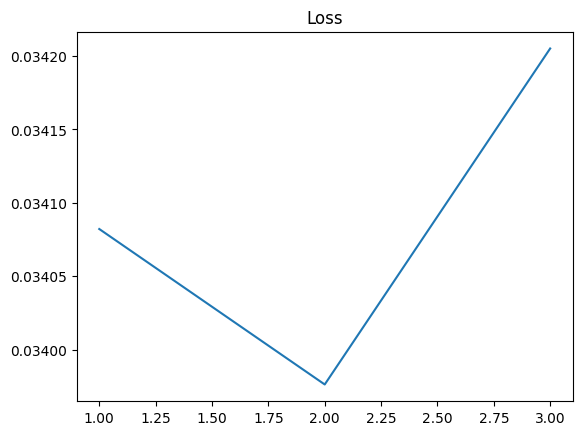

In [9]:
# 損失の可視化
import matplotlib.pyplot as plt

train_loss_history = np.array(train_loss_history) # y軸
epochs = np.arange(1, len(train_loss_history)+1) # x軸
plt.title('Loss')
plt.plot(epochs, train_loss_history)
plt.show()

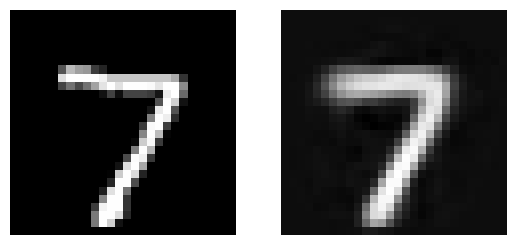

In [10]:
# おまけ
x, _ = next(iter(test_dataloader))
x = x.to(device)

model.eval()
x_rec = model(x)

import matplotlib.pyplot as plt
for i, image in enumerate([x, x_rec]):
    image = image.view(28, 28).detach().cpu().numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.show()